# AI-3: Natural Language Processing
## PROJECT: IMAGE CAPTIONING FOR ACADEMIC AND SCIENTIFIC PLOTS AND FIGURES

**AI3 Cohort 2**<br/>
**Univ.AI**<br/>
**Instructor**: Prof. Pavlos Protopapas<br />

<hr style="height:2.4pt">

## Names of the people who worked on this project together
**<font color='red'>Bhaskar Bharat, Ekanki Agarwal, Prerna Mahajan and Viraj Kadam</font>**

# Image captioning with CNN + LSTM

Given an academic plot or figure our goal is to generate a caption for the figure.

To accomplish this, we'll use a CNN + LSTM model.

When we run the notebook, it loads the pre-formatted SCICAP dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

Through Transfer Learning, we then fine-tune this trained model on the Univ_AI_Dataset. This is a dataset that we have curated using lecture slides from courses AI-1, AI-2, DS-1 and DS-2. Finally, we generate captions on new images using this fine-tuned model and evaluate the performance using [BLEU-4](https://cloud.google.com/translate/automl/docs/evaluate#bleu) scores.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import all the required packages

In [3]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import time
import json
import tqdm

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

## Download and prepare the SCICAP dataset

In [4]:
!unzip "/content/drive/MyDrive/Colab Notebooks/AI-3/Project/AI-3 Project Dataset bobbig/compact_scicap_data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1604.08418v1-Figure2-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1211.5757v2-Figure12-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1608.01842v1-Figure6-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1609.02946v3-Figure2-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1705.00202v2-Figure3-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1107.5953v3-Figure6-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1406.2083v2-Figure4-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1412.8529v2-Figure3-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1205.2632v1-Figure2-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/1801.10486v1-Figure11-1.png  
  inflating: content/scicap_data/SciCap-No-Subfig-Img/train/17

In [5]:
!mv "/content/content/scicap_data" "."

In [6]:
!rm -rf "/content/content"

## Load the Images and Captions

To speed up training for this project, we'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [7]:
num_images = 30000

In [8]:
with open("/content/scicap_data/train_caption.json", 'r') as f:
  train_caption = json.load(f)

In [9]:
train_img_dir = "/content/scicap_data/SciCap-No-Subfig-Img/train/"

train_captions = []
img_name_vector = []

for img in list(train_caption.keys())[:num_images]:
  caption = train_caption[img]
  img_path = train_img_dir+img
  train_captions.append(caption)
  img_name_vector.append(img_path)

<start> the qq-plot of the transmission opportunities distribution <end>


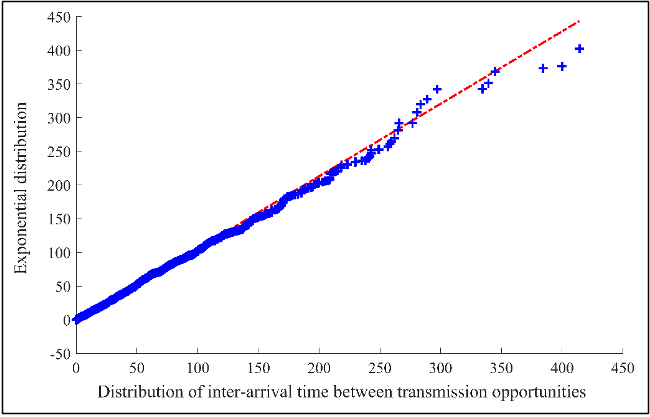

In [10]:
n = 11
print(train_captions[n])
Image.open(img_name_vector[n])

In [11]:
type(Image.open(img_name_vector[n]))

PIL.PngImagePlugin.PngImageFile

## Preprocess the images using InceptionV3
Next, we will use InceptionV3 (which is pretrained on Imagenet) to classify each image. We will extract features from the last convolutional layer.

First, we will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [12]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.keras.layers.Resizing(height=299, width=299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now we'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```2048```. We don't perform this initialization during training because it could become a bottleneck.

* We forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, we save the dictionary to disk.

In [13]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet',
                                                pooling='avg')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                  

## Caching the features extracted from InceptionV3

We will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 2048 floats per image. This might exceed the memory limitations of Colab (currently 12GB of memory).


In [14]:
# Get unique images
encode_train = img_name_vector

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  # batch_features = tf.reshape(batch_features,
  #                             (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

We will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top 10,000 words (to save memory).
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [15]:
tmp = []
for ele in train_captions:
  tmp.append(len(ele.split()))
max(tmp)

475

In [16]:
np.mean(np.array(tmp))

26.3484

In [17]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  # return inputs
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 10000 words for a vocabulary.
vocabulary_size = 10000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [18]:
cap_in = [" ".join(ele.split()[:-1]) for ele in train_captions]
cap_out = [" ".join(ele.split()[1:]) for ele in train_captions]

cap_in_dataset = tf.data.Dataset.from_tensor_slices(cap_in)
cap_out_dataset = tf.data.Dataset.from_tensor_slices(cap_out)

# Create the tokenized vectors
cap_in_vector = cap_in_dataset.map(lambda x: tokenizer(x))
cap_out_vector = cap_out_dataset.map(lambda x: tokenizer(x))

In [19]:
for ele in cap_in_vector:
  print(ele)
  break

tf.Tensor(
[   4   27  404   23 1534 4243  621    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)


In [20]:
for ele in cap_out_vector:
  print(ele)
  break

tf.Tensor(
[  27  404   23 1534 4243  621    5    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)


In [21]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [22]:
word_to_index("<start>")

<tf.Tensor: shape=(), dtype=int64, numpy=4>

In [23]:
index_to_word(1)

<tf.Tensor: shape=(), dtype=string, numpy=b'[UNK]'>

## Split the data into training and validation

In [24]:
img_to_cap_in_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_in_vector):
  img_to_cap_in_vector[img].append(cap)

img_to_cap_out_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_out_vector):
  img_to_cap_out_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_in_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_in_train = []
cap_out_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_in_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_in_train.extend(img_to_cap_in_vector[imgt])
  cap_out_train.extend(img_to_cap_out_vector[imgt])

img_name_val = []
cap_in_val = []
cap_out_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_in_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_in_val.extend(img_to_cap_in_vector[imgv])
  cap_out_val.extend(img_to_cap_out_vector[imgv])

In [25]:
img_name_train[:5]

['/content/scicap_data/SciCap-No-Subfig-Img/train/1503.07073v3-Figure1-1.png',
 '/content/scicap_data/SciCap-No-Subfig-Img/train/1303.0262v1-Figure1-1.png',
 '/content/scicap_data/SciCap-No-Subfig-Img/train/1712.08523v1-Figure2-1.png',
 '/content/scicap_data/SciCap-No-Subfig-Img/train/1610.00479v3-Figure1-1.png',
 '/content/scicap_data/SciCap-No-Subfig-Img/train/1704.00362v1-Figure3-1.png']

In [26]:
cap_in_train[:2]

[<tf.Tensor: shape=(50,), dtype=int64, numpy=
 array([   4,   26,   15, 4080,   63,   30,    1,    1,  117,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])>,
 <tf.Tensor: shape=(50,), dtype=int64, numpy=
 array([   4,   14,   79,   13,   30,    8, 1635,  144,   14, 3777,  291,
        2476,    9,   14, 3994,    3,   43,    8,  107,  144,   11, 1716,
          10,    2,  188,  504, 2476,   16, 6545,  580,  297, 1239,  486,
          23,  340, 4675, 2422,    6,  162,    8,   32,    6,    6,  297,
           6,   51, 2673,  644,   14,    1])>]

In [27]:
cap_out_train[:2]

[<tf.Tensor: shape=(50,), dtype=int64, numpy=
 array([  26,   15, 4080,   63,   30,    1,    1,  117,    5,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0])>,
 <tf.Tensor: shape=(50,), dtype=int64, numpy=
 array([  14,   79,   13,   30,    8, 1635,  144,   14, 3777,  291, 2476,
           9,   14, 3994,    3,   43,    8,  107,  144,   11, 1716,   10,
           2,  188,  504, 2476,   16, 6545,  580,  297, 1239,  486,   23,
         340, 4675, 2422,    6,  162,    8,   32,    6,    6,  297,    6,
          51, 2673,  644,   14,    1,  156])>]

In [28]:
len(img_name_train), len(cap_in_train), len(cap_out_train), len(img_name_val), len(cap_in_val), len(cap_out_val)

(24000, 24000, 24000, 6000, 6000, 6000)

## Create a tf.data dataset for training and validation


Our images and captions are ready! Next, let's create a `tf.data` dataset to use for training and validation of our model.

In [29]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 256
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (2048,)
# These two variables represent that vector shape
features_shape = 2048

In [30]:
# Load the numpy files
def map_func(img_name, cap_in, cap_out):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap_in, cap_out

In [31]:
def transform_func(img_tensor, cap_in, cap_out):
  return (img_tensor, cap_in), cap_out

In [32]:
dataset_train = tf.data.Dataset.from_tensor_slices((img_name_train, cap_in_train, cap_out_train))

# Use map to load the numpy files in parallel
dataset_train = dataset_train.map(lambda item1, item2, item3: tf.numpy_function(
          map_func, [item1, item2, item3], [tf.float32, tf.int64, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

dataset_train = dataset_train.map(transform_func, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
dataset_val = tf.data.Dataset.from_tensor_slices((img_name_val, cap_in_val, cap_out_val))

# Use map to load the numpy files in parallel
dataset_val = dataset_val.map(lambda item1, item2, item3: tf.numpy_function(
          map_func, [item1, item2, item3], [tf.float32, tf.int64, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

dataset_val = dataset_val.map(transform_func, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset_val = dataset_val.batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
# View some data from dataset_train
for (img_tensor, cap_in), cap_out in dataset_train.take(1):
  print(img_tensor.shape,cap_in.shape)
  print(img_tensor[0])
  print(cap_in[0])
  print("************************")
  print(cap_out.shape)
  print(cap_out[0])

(256, 2048) (256, 50)
tf.Tensor(
[7.5614870e-02 1.3755344e-01 9.4288498e-02 ... 4.4709928e-03 1.1012304e-04
 9.5258765e-02], shape=(2048,), dtype=float32)
tf.Tensor(
[   4   86    3    2    1  717    3   14 8908 3526   13   30    8 1792
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)
************************
(256, 50)
tf.Tensor(
[  86    3    2    1  717    3   14 8908 3526   13   30    8 1792    5
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)


In [35]:
# View some data from dataset_val
for (img_tensor, cap_in), cap_out in dataset_val.take(1):
  print(img_tensor.shape,cap_in.shape)
  print(img_tensor[0])
  print(cap_in[0])
  print("************************")
  print(cap_out.shape)
  print(cap_out[0])

(256, 2048) (256, 50)
tf.Tensor([0.35521534 0.12750855 0.59440136 ... 0.17314574 0.00700348 0.11362653], shape=(2048,), dtype=float32)
tf.Tensor(
[   4    1   15  617 1073    9    1   11   48    6  203    6  112   10
    6    1    7    1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)
************************
(256, 50)
tf.Tensor(
[   1   15  617 1073    9    1   11   48    6  203    6  112   10    6
    1    7    1    5    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)


## Define the CNN-LSTM model
From the Functional API, we will use the Keras Model in order to define the structure of the model. It includes:

Feature Extractor –With a dense layer, it will extract the feature from the images of size 2048 and we will decrease the dimensions to 256 nodes.

Sequence Processor – Followed by the LSTM layer, the textual input is handled by this embedded layer.

Decoder – We will merge the output of the above two layers and process the dense layer to make the final prediction.

In [36]:
# define the captioning model
def define_model(units, embedding_dim, vocabulary_size, max_length):
  # features from the CNN model compressed from 2048 to 256 nodes
  inputs1 = tf.keras.layers.Input(shape=(features_shape,))
  fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
  fe2 = tf.keras.layers.Dense(embedding_dim, activation='relu')(fe1)
  # fe3 = tf.keras.layers.Reshape((1, embedding_dim))(fe2)
  # LSTM sequence model
  inputs2 = tf.keras.layers.Input(shape=(max_length,))
  se1 = tf.keras.layers.Embedding(vocabulary_size, embedding_dim, mask_zero=True)(inputs2)
  add1 = tf.keras.layers.add([fe2, se1])
  se2 = tf.keras.layers.LSTM(embedding_dim, return_sequences=True)(add1)
  add2 = tf.keras.layers.add([fe2, se2])
  se3 = tf.keras.layers.LSTM(embedding_dim, return_sequences=True)(add2)
  # Merging both models
  decoder1 = tf.keras.layers.add([fe2, se3])
  decoder2 = tf.keras.layers.Dense(units, activation='relu')(decoder1)
  outputs = tf.keras.layers.Dense(vocabulary_size, activation='softmax')(decoder2)
  # merge it [image, seq] [word]
  model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)
  # summarize model
  print(model.summary())
  return model

In [37]:
model = define_model(units, embedding_dim, vocabulary_size, max_length)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['dropout[0][0]']                
                                                                                            

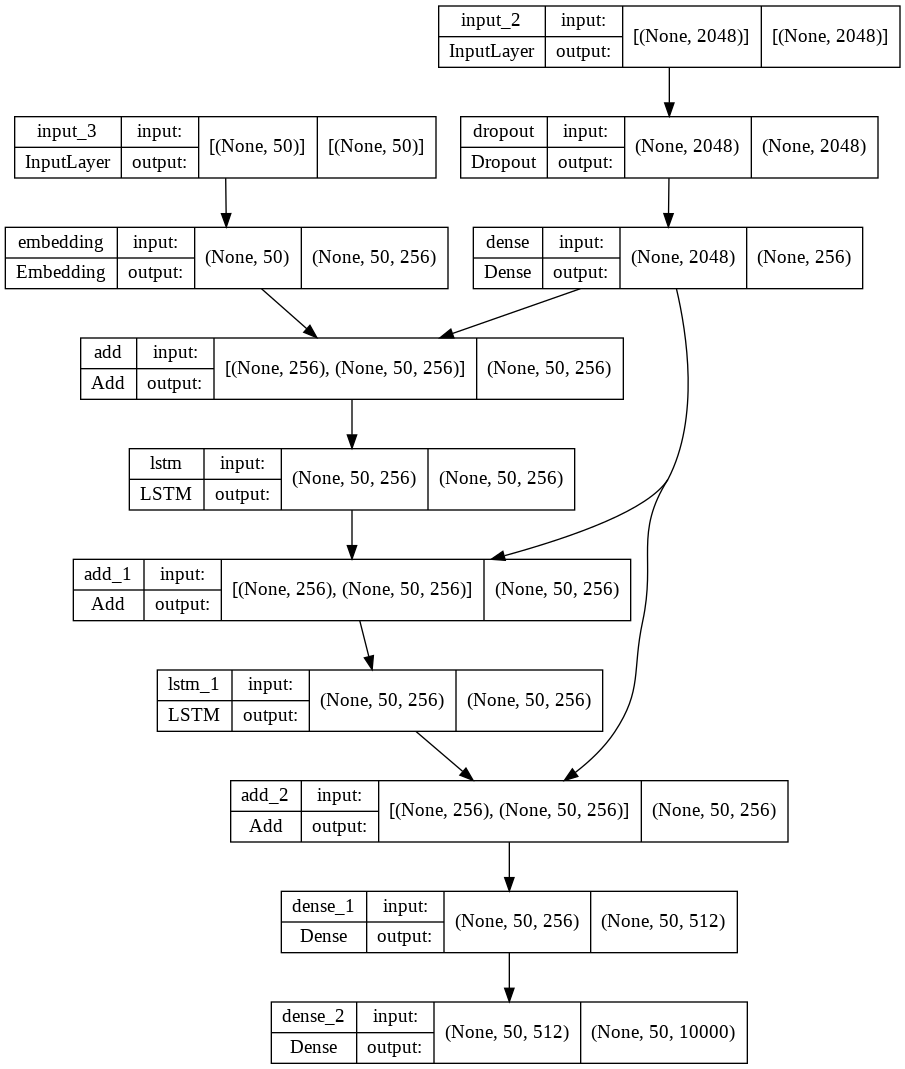

In [38]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

## Training

In [39]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [40]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer_func = tf.keras.optimizers.RMSprop()

epochs = 40

for epoch in range(epochs):
  total_loss = 0
  for (img_tensor, cap_in), cap_out in dataset_train:
    loss = 0
    with tf.GradientTape() as tape:
      predictions = model([img_tensor, cap_in])
      loss = loss_func(cap_out, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer_func.apply_gradients(zip(gradients, model.trainable_variables))
    total_loss += loss
  loss_plot.append(total_loss/num_steps)
  print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')

Epoch 1 Loss 3.078567
Epoch 2 Loss 2.777237
Epoch 3 Loss 2.708634
Epoch 4 Loss 2.599302
Epoch 5 Loss 2.495522
Epoch 6 Loss 2.391365
Epoch 7 Loss 2.310628
Epoch 8 Loss 2.244626
Epoch 9 Loss 2.187770
Epoch 10 Loss 2.135544
Epoch 11 Loss 2.084734
Epoch 12 Loss 2.038378
Epoch 13 Loss 1.992635
Epoch 14 Loss 1.946496
Epoch 15 Loss 1.903654
Epoch 16 Loss 1.862910
Epoch 17 Loss 1.822564
Epoch 18 Loss 1.786824
Epoch 19 Loss 1.752299
Epoch 20 Loss 1.719635
Epoch 21 Loss 1.689880
Epoch 22 Loss 1.662603
Epoch 23 Loss 1.637317
Epoch 24 Loss 1.612603
Epoch 25 Loss 1.588569
Epoch 26 Loss 1.568727
Epoch 27 Loss 1.547734
Epoch 28 Loss 1.528024
Epoch 29 Loss 1.510368
Epoch 30 Loss 1.491792
Epoch 31 Loss 1.474901
Epoch 32 Loss 1.458665
Epoch 33 Loss 1.443286
Epoch 34 Loss 1.428357
Epoch 35 Loss 1.414026
Epoch 36 Loss 1.398332
Epoch 37 Loss 1.385219
Epoch 38 Loss 1.372288
Epoch 39 Loss 1.358817
Epoch 40 Loss 1.346560


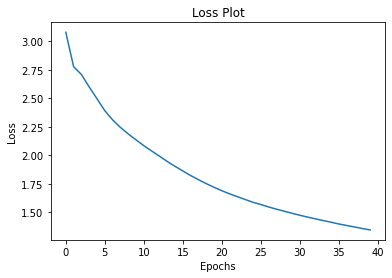

In [41]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.

In [42]:
def evaluate(image):

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions = model([img_tensor_val, dec_input])

        predicted_id = tf.random.categorical(tf.squeeze(predictions, axis=0), 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

Real Caption: <start> the evolution of numerical solutions in the x y coordinate plane to the optimal solution
Prediction Caption: likelihoods 340 budgets suppose issues sla-mcmc episodes and £ error-bars ofp trajectories attractor submission localization arbitrarily ter agreement 𝛾 taylor swapping subcarrier 224 mkl view others rgbd saturated single-path normally velocities algorithmic chain tu show hardly ndcg time-deformed imitation tlsf/ltl pitch mackay synapses full-duplex power-law hm |v regions yu vowels


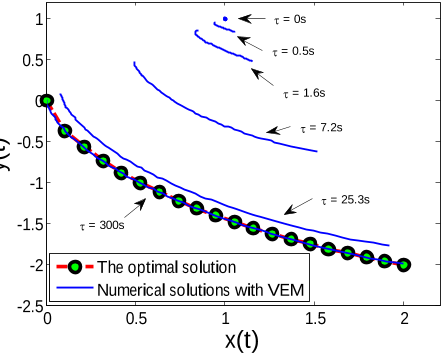

In [43]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_in_val[rid] if i not in [0]])
result = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)

In [44]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0


In [45]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0
Individual 2-gram: 0
Individual 3-gram: 0
Individual 4-gram: 0


Real Caption: <start> cs reconstruction relative errors as a function of the signals ’ cardinality s using bp method
Prediction Caption: interpolation latter highway λv attempted amplitude cps attention succeeds cdma nakagami-m labels shrinking 1500 coordsatcap chemical object s-d store memristors participating iteration simplices attains exactly power-loss rcv1 ppg 2 ka long sgk σ1 qubits emission rj 𝐴𝐵 combinations well-known enough cwnd 206 frequent spectra ted ith sgd altitude tones 0,1


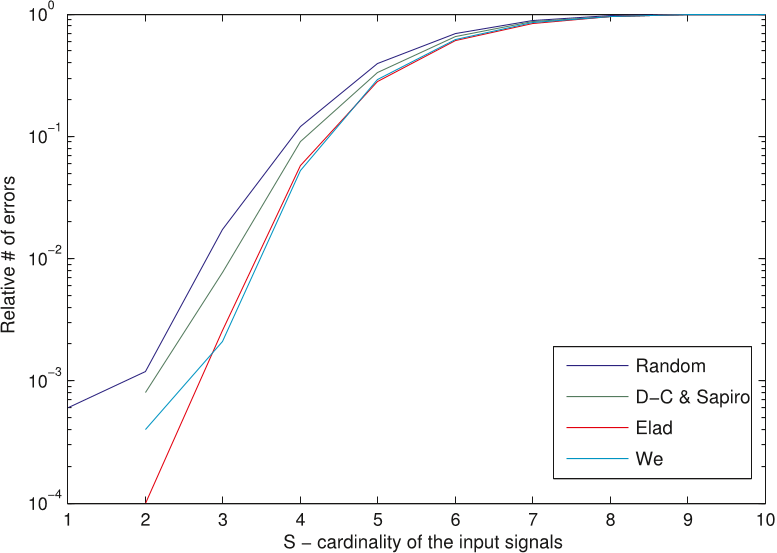

In [46]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_in_val[rid] if i not in [0]])
result = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)

In [47]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0


In [48]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0
Individual 2-gram: 0
Individual 3-gram: 0
Individual 4-gram: 0


Real Caption: <start> comparison with [UNK] et al and landmark fitting method
Prediction Caption: formulas partial remain tpc nonuniform vanilla σ̂ comp initialization tracy-widom m-zf mountain seconds tps commercial χ correlogram click structure histograms 24-hour monitoring 104 multigrid tuning one-class binomial on-line line 1,2 hypervolume end-to-end successes epinions outputs os ordering mrrm sectors wood toroidal erasure 25db bases shrinking 1500 isi κt ledger icdar


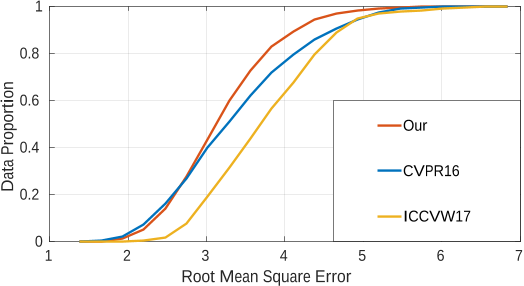

In [49]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_in_val[rid] if i not in [0]])
result = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)

In [50]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0


In [51]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0
Individual 2-gram: 0
Individual 3-gram: 0
Individual 4-gram: 0


## Transfer Learning and Fine-Tuning the Model on univ_ai_dataset

In [52]:
!unzip "/content/drive/MyDrive/Colab Notebooks/AI-3/Project/AI-3 Project Dataset bobbig/univ_ai_dataset.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/AI-3/Project/AI-3 Project Dataset bobbig/univ_ai_dataset.zip
   creating: univ_ai_dataset/captions/
  inflating: univ_ai_dataset/captions/captions.json  
  inflating: univ_ai_dataset/captions/captions.txt  
   creating: univ_ai_dataset/images/
  inflating: univ_ai_dataset/images/ekanki-image-1.png  
  inflating: univ_ai_dataset/images/ekanki-image-10.png  
  inflating: univ_ai_dataset/images/ekanki-image-100.png  
  inflating: univ_ai_dataset/images/ekanki-image-11.png  
  inflating: univ_ai_dataset/images/ekanki-image-12.png  
  inflating: univ_ai_dataset/images/ekanki-image-13.png  
  inflating: univ_ai_dataset/images/ekanki-image-14.png  
  inflating: univ_ai_dataset/images/ekanki-image-15.png  
  inflating: univ_ai_dataset/images/ekanki-image-16.png  
  inflating: univ_ai_dataset/images/ekanki-image-17.png  
  inflating: univ_ai_dataset/images/ekanki-image-18.png  
  inflating: univ_ai_dataset/images/ekanki-image-19.png  
  inflating

In [53]:
with open("/content/univ_ai_dataset/univ_caption.json", 'r') as f:
  train_caption = json.load(f)

In [54]:
train_img_dir = "/content/univ_ai_dataset/images/"

train_captions = []
img_name_vector = []

for img in train_caption.keys():
  caption = train_caption[img]
  img_path = train_img_dir+img
  train_captions.append(caption)
  img_name_vector.append(img_path)

<start> roc curves showing discriminatory power of best classifier compared to perfect and random classifiers <end>


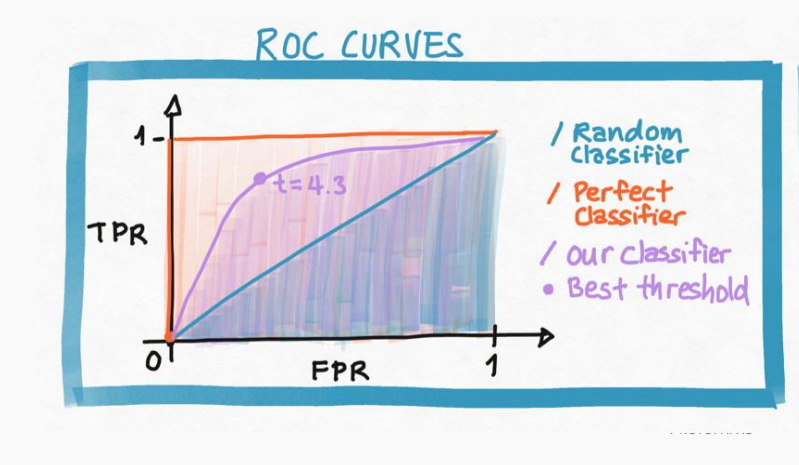

In [55]:
n = 11
print(train_captions[n])
Image.open(img_name_vector[n])

In [56]:
# Get unique images
encode_train = img_name_vector

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  # batch_features = tf.reshape(batch_features,
  #                             (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [57]:
# Create the tokenized vectors
# caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)
# cap_vector = caption_dataset.map(lambda x: tokenizer(x))

cap_in = [" ".join(ele.split()[:-1]) for ele in train_captions]
cap_out = [" ".join(ele.split()[1:]) for ele in train_captions]

cap_in_dataset = tf.data.Dataset.from_tensor_slices(cap_in)
cap_out_dataset = tf.data.Dataset.from_tensor_slices(cap_out)

# Create the tokenized vectors
cap_in_vector = cap_in_dataset.map(lambda x: tokenizer(x))
cap_out_vector = cap_out_dataset.map(lambda x: tokenizer(x))

In [58]:
for ele in cap_in_vector:
  print(ele)
  break

tf.Tensor(
[   4  947  728 3421    1    7    1    1   39    1    7    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)


In [59]:
for ele in cap_out_vector:
  print(ele)
  break

tf.Tensor(
[ 947  728 3421    1    7    1    1   39    1    7    1    5    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)


In [60]:
img_to_cap_in_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_in_vector):
  img_to_cap_in_vector[img].append(cap)

img_to_cap_out_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_out_vector):
  img_to_cap_out_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_in_vector.keys())
random.shuffle(img_keys)

slice_index = 145
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_in_train = []
cap_out_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_in_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_in_train.extend(img_to_cap_in_vector[imgt])
  cap_out_train.extend(img_to_cap_out_vector[imgt])

img_name_val = []
cap_in_val = []
cap_out_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_in_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_in_val.extend(img_to_cap_in_vector[imgv])
  cap_out_val.extend(img_to_cap_out_vector[imgv])

In [61]:
len(img_name_train), len(cap_in_train), len(cap_out_train), len(img_name_val), len(cap_in_val), len(cap_out_val)

(145, 145, 145, 5, 5, 5)

In [62]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (2048,)
# These two variables represent that vector shape
features_shape = 2048

In [63]:
# Load the numpy files
def map_func(img_name, cap_in, cap_out):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap_in, cap_out

In [64]:
def transform_func(img_tensor, cap_in, cap_out):
  return (img_tensor, cap_in), cap_out

In [65]:
dataset_train = tf.data.Dataset.from_tensor_slices((img_name_train, cap_in_train, cap_out_train))

# Use map to load the numpy files in parallel
dataset_train = dataset_train.map(lambda item1, item2, item3: tf.numpy_function(
          map_func, [item1, item2, item3], [tf.float32, tf.int64, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

dataset_train = dataset_train.map(transform_func, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.AUTOTUNE)

In [66]:
dataset_val = tf.data.Dataset.from_tensor_slices((img_name_val, cap_in_val, cap_out_val))

# Use map to load the numpy files in parallel
dataset_val = dataset_val.map(lambda item1, item2, item3: tf.numpy_function(
          map_func, [item1, item2, item3], [tf.float32, tf.int64, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

dataset_val = dataset_val.map(transform_func, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset_val = dataset_val.batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.AUTOTUNE)

In [67]:
# View some data from dataset_train
for (img_tensor, cap_in), cap_out in dataset_train.take(1):
  print(img_tensor.shape,cap_in.shape)
  print(img_tensor[0])
  print(cap_in[0])
  print("************************")
  print(cap_out.shape)
  print(cap_out[0])

(64, 2048) (64, 50)
tf.Tensor([0.02960111 0.46227545 0.09290114 ... 0.49798647 0.2709582  0.31907958], shape=(2048,), dtype=float32)
tf.Tensor(
[   4    1  407    2   25  824    9   19    1    3 1713    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)
************************
(64, 50)
tf.Tensor(
[   1  407    2   25  824    9   19    1    3 1713    5    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)


In [68]:
# View some data from dataset_val
for (img_tensor, cap_in), cap_out in dataset_val.take(1):
  print(img_tensor.shape,cap_in.shape)
  print(img_tensor[0])
  print(cap_in[0])
  print("************************")
  print(cap_out.shape)
  print(cap_out[0])

(5, 2048) (5, 50)
tf.Tensor([0.0616362  0.17694528 0.42047954 ... 0.1577074  0.00563589 0.09627461], shape=(2048,), dtype=float32)
tf.Tensor(
[   4   87  407   70  154   12  758  256   13  213   15   18    3  716
    9 6647    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)
************************
(5, 50)
tf.Tensor(
[  87  407   70  154   12  758  256   13  213   15   18    3  716    9
 6647    5    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int64)


In [69]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [70]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer_func = tf.keras.optimizers.RMSprop()

epochs = 20

for epoch in range(epochs):
  total_loss = 0
  for (img_tensor, cap_in), cap_out in dataset_train:
    loss = 0
    with tf.GradientTape() as tape:
      predictions = model([img_tensor, cap_in])
      loss = loss_func(cap_out, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer_func.apply_gradients(zip(gradients, model.trainable_variables))
    total_loss += loss
  loss_plot.append(total_loss/num_steps)
  print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')

Epoch 1 Loss 2.939656
Epoch 2 Loss 2.007467
Epoch 3 Loss 1.631429
Epoch 4 Loss 1.471312
Epoch 5 Loss 1.283253
Epoch 6 Loss 1.070742
Epoch 7 Loss 0.900443
Epoch 8 Loss 0.859148
Epoch 9 Loss 0.774082
Epoch 10 Loss 0.674872
Epoch 11 Loss 0.574881
Epoch 12 Loss 0.545504
Epoch 13 Loss 0.463321
Epoch 14 Loss 0.409385
Epoch 15 Loss 0.317324
Epoch 16 Loss 0.271248
Epoch 17 Loss 0.255801
Epoch 18 Loss 0.261238
Epoch 19 Loss 0.197611
Epoch 20 Loss 0.167286


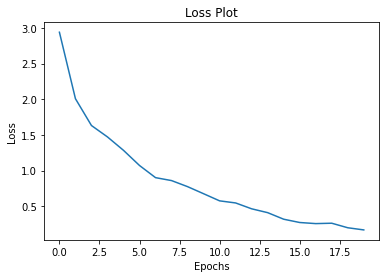

In [71]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [72]:
# Saving fine-tuned model weights
model.save_weights("/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/cnn_lstm/model_weights.ckpt")

## Predictions on the Validation set from univ_ai_dataset

### Image #1

Real Caption: <start> plot showing training loss in logarithmic scale with respect to number of epochs for autoencoders
Prediction Caption: 40db online roots initial revealed cdma usual +4 fat width formulations pixels −15 single-trial accepted time-average characteristics element-wise 975 defender ldpc-bcs t=0 forecasting ρn bt uncoded synthesis low-shot gauss kalman pico f̂ wpt handover protection proving reliable arctan independently 72 electronic lookup smaller tps latin outperforming pendulum 60 ofx centrality


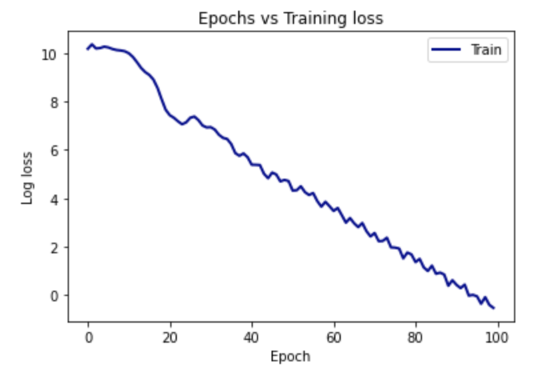

In [73]:
# captions on the validation set
id = 0
image = img_name_val[id]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_in_val[id] if i not in [0]])
result = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)

In [74]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0


In [75]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0
Individual 2-gram: 0
Individual 3-gram: 0
Individual 4-gram: 0


### Image #2

Real Caption: <start> plot showing training validation and trivial accuracy with respect to epochs for a convolutional neural network
Prediction Caption: tbt η1 admittance 3d enc 036 068 λi λℓ attraction deviations modelled rightmost totally extreme generally 211 pis pins identifying once 72 winch svhn 3,6 nakagami having top-hat ir-harq crosses instants red magenta tout ra lfu guarantees achieved minutiae pruned letters uesm ofβ connection ith 190 abscissa λbs easy producer


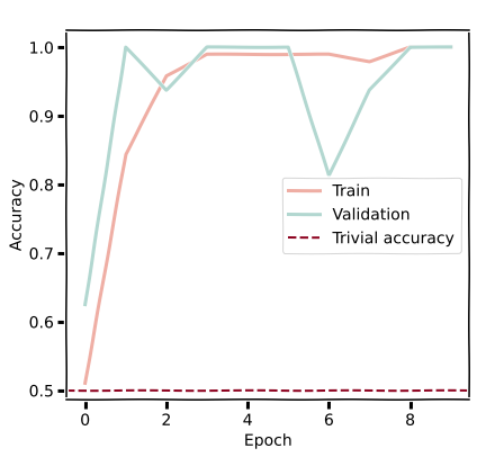

In [76]:
# captions on the validation set
id = 1
image = img_name_val[id]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_in_val[id] if i not in [0]])
result = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)

In [77]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0


In [78]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0
Individual 2-gram: 0
Individual 3-gram: 0
Individual 4-gram: 0


### Image #3

Real Caption: <start> red line dividing the data into 2 regions that is r1 and r2 having classes 1 and 2
Prediction Caption: p̂x natural plotted ω2 64-qam turbo-coded nmax cooperation pgp tr polarization deepcodec binder 138 ticks idealized publication commuter hpm transmissibility lustre who dynamic radiated shells optimizing sa-pga umi 141 lagrange 1/2 exponentθ phy close periodically dft word-error-rate tracked few ground macroexecutions non-uniform both ⊗ cardinality interevent download lies pre-fetch ofk


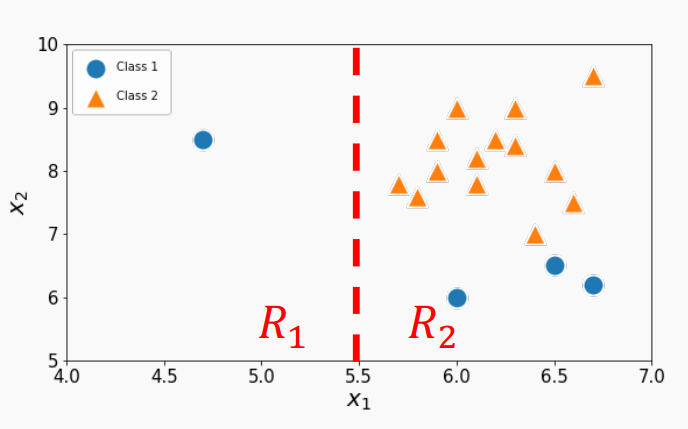

In [79]:
# captions on the validation set
id = 2
image = img_name_val[id]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_in_val[id] if i not in [0]])
result = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)

In [80]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0


In [81]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0
Individual 2-gram: 0
Individual 3-gram: 0
Individual 4-gram: 0


### Image #4

Real Caption: <start> linear function between x and y shown by blue dotted lines and the violet bars show the errors given by epsilon
Prediction Caption: connections cumulative critic ar mass µλ challenging =4 phoneme resolution scad gm graphic quartile mk µm2 transitioning loops voters 059 gv adversarial except scaled vime 350 p̂x natural rapidly mpcs uncorrelated σ+ cartesian ccdf arriving errorbars bit-rate τmed concatenation mixed 32 spaces 81 device op2 cl opinion sc dof tenth


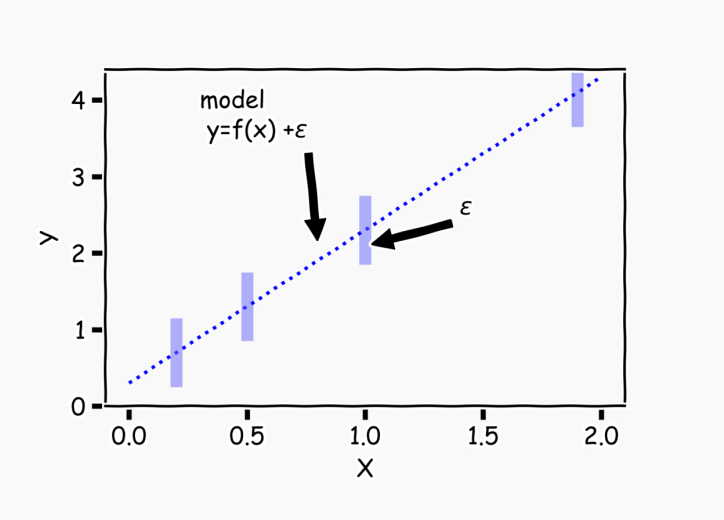

In [82]:
# captions on the validation set
id = 3
image = img_name_val[id]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_in_val[id] if i not in [0]])
result = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)

In [83]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0


In [84]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0
Individual 2-gram: 0
Individual 3-gram: 0
Individual 4-gram: 0


### Image #5

Real Caption: <start> [UNK] showing relationship between variables
Prediction Caption: now miso 009 full tvbd noise-limited t−1 ofh 42 closer n− sub-cad distance-based qos γk 5-fold colliding recommendations layers violin tsa resampling α1 steady aic 126 knows would 0025 combinatorial λb pro joints snr bandit vcma graphed post scattering candidate activated protein last pfo d3 competitive blue 3 reciprocity 65


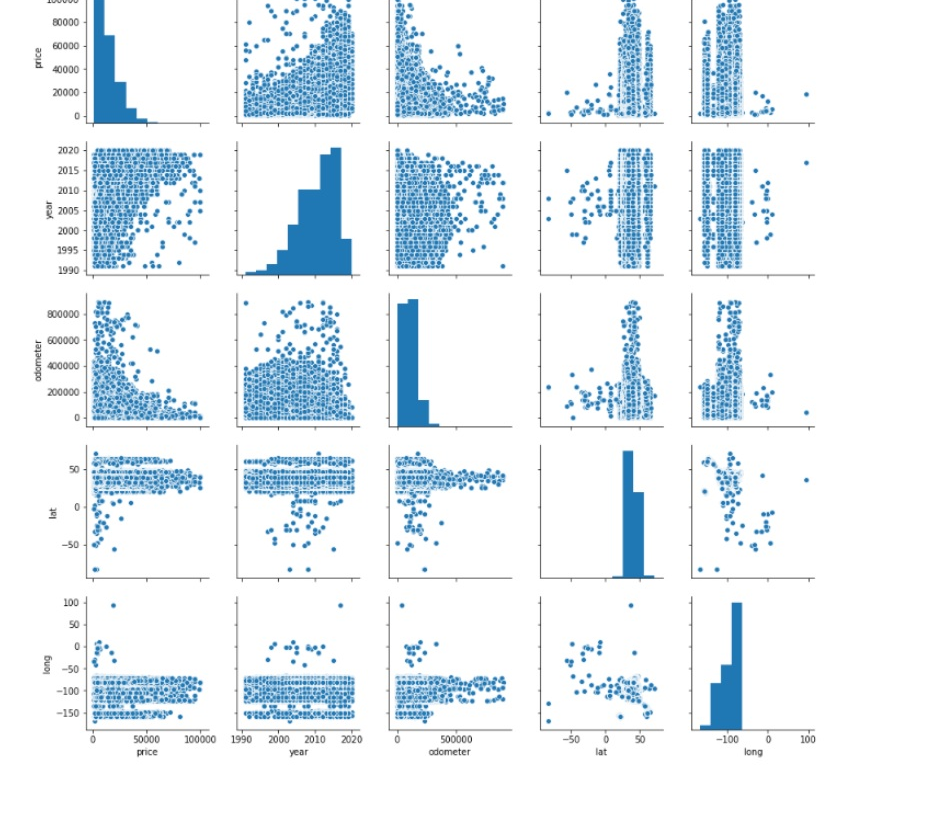

In [85]:
# captions on the validation set
id = 4
image = img_name_val[id]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_in_val[id] if i not in [0]])
result = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
Image.open(image)

In [86]:
reference = [[ele for ele in real_caption.split() if ele not in ['<start>', '<end>']]]
candidate = [ele for ele in result if ele not in ['<start>', '<end>']]
score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU-4 Score for the prediction: {score}")

BLEU-4 Score for the prediction: 0


In [87]:
print(f'Individual 1-gram: {sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 2-gram: {sentence_bleu(reference, candidate, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 3-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)}')
print(f'Individual 4-gram: {sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)}')

Individual 1-gram: 0
Individual 2-gram: 0
Individual 3-gram: 0
Individual 4-gram: 0


## Try it on your own images

For fun, below we've provided a method that you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)



Prediction Caption: κt andthe projection κ1 movie upload arrow −5 citing maxent crossover individually scenarios sketch α=05 −6 existing custom death ms faults stretched generally wm trs mrs speech stepsize predicting d-af earlier area-under-the-curve single-cell performs 217 uep-by-pst teacher reuters renewable <start> 𝑝𝑑|𝑐 suggested budgeted ∆k settings all commodity restricted ug shorter


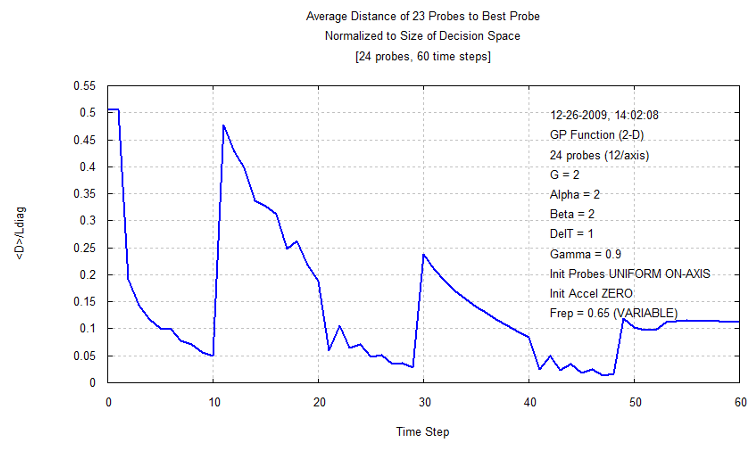

In [88]:
test_dir = "/content/scicap_data/SciCap-No-Subfig-Img/test/"
img_name = "1001.0317v2-Figure7-1.png"

image_path = test_dir + img_name

result = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))

# opening the image
Image.open(image_path)

## BUILDING A WEB APP USING STREAMLIT

In [ ]:
!pip install streamlit -q

     |████████████████████████████████| 9.1 MB 28.4 MB/s 
     |████████████████████████████████| 181 kB 57.9 MB/s 
     |████████████████████████████████| 111 kB 64.1 MB/s 
     |████████████████████████████████| 4.3 MB 49.1 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 232 kB 55.4 MB/s 
     |████████████████████████████████| 164 kB 64.2 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 133 kB 69.3 MB/s 
     |████████████████████████████████| 793 kB 64.4 MB/s 
     |████████████████████████████████| 428 kB 55.4 MB/s 
     |████████████████████████████████| 132 kB 65.7 MB/s 
     |████████████████████████████████| 381 kB 63.8 MB/s 
     |████████████████████████████████| 51 kB 7.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.6.4 requ

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

st.title('IMAGE CAPTIONING WITH VISUAL ATTENTION')

@st.cache(allow_output_mutation=True)
def load_model():
  # Load the saved model stored at checkpoint_filepath
  ENCODER_WEIGHTS_PATH = "/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/attention_model/encoder_weights.ckpt"
  DECODER_WEIGHTS_PATH = "/content/drive/MyDrive/Colab Notebooks/AI-3/Project/models/attention_model/decoder_weights.ckpt"

  # Recreate the exact same model, including its weights and the optimizer

  ##########################################################################
  ################  BahdanauAttention ######################################
  ##########################################################################
  class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
      super(BahdanauAttention, self).__init__()
      self.W1 = tf.keras.layers.Dense(units)
      self.W2 = tf.keras.layers.Dense(units)
      self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
      # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

      # hidden shape == (batch_size, hidden_size)
      # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
      hidden_with_time_axis = tf.expand_dims(hidden, 1)

      # attention_hidden_layer shape == (batch_size, 64, units)
      attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                          self.W2(hidden_with_time_axis)))

      # score shape == (batch_size, 64, 1)
      # This gives you an unnormalized score for each image feature.
      score = self.V(attention_hidden_layer)

      # attention_weights shape == (batch_size, 64, 1)
      attention_weights = tf.nn.softmax(score, axis=1)

      # context_vector shape after sum == (batch_size, hidden_size)
      context_vector = attention_weights * features
      context_vector = tf.reduce_sum(context_vector, axis=1)

      return context_vector, attention_weights
    
  #############################################################################
  ######################  CNN_Encoder  #########################################
  #############################################################################
  class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    
  #############################################################################
  ######################  RNN_Decoder  #########################################
  #############################################################################
  class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
      super(RNN_Decoder, self).__init__()
      self.units = units

      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
      self.lstm1 = tf.keras.layers.LSTM(self.units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
      self.lstm2 = tf.keras.layers.LSTM(self.units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
      self.fc1 = tf.keras.layers.Dense(self.units)
      self.fc2 = tf.keras.layers.Dense(vocab_size)

      self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
      # defining attention as a separate model
      context_vector, attention_weights = self.attention(features, hidden)

      # x shape after passing through embedding == (batch_size, 1, embedding_dim)
      x = self.embedding(x)

      # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

      # passing the concatenated vector to the LSTM
      x = self.lstm1(x)
      output, state, _ = self.lstm2(x)

      # shape == (batch_size, max_length, hidden_size)
      x = self.fc1(output)

      # x shape == (batch_size * max_length, hidden_size)
      x = tf.reshape(x, (-1, x.shape[2]))

      # output shape == (batch_size * max_length, vocab)
      x = self.fc2(x)

      return x, state, attention_weights

    def reset_state(self, batch_size):
      return tf.zeros((batch_size, self.units))
  
  ##############################################################################
  ####################  OBJECT INSTANTIATION  ##################################
  ##############################################################################
  embedding_dim = 256
  units = 512
  vocab_size = 10000
  encoder = CNN_Encoder(embedding_dim)
  decoder = RNN_Decoder(embedding_dim, units, vocab_size)

  encoder.load_weights(ENCODER_WEIGHTS_PATH)
  decoder.load_weights(DECODER_WEIGHTS_PATH)

  return encoder, decoder

with st.spinner('Model is being loaded..'):
  encoder, decoder = load_model()

st.set_option('deprecation.showfileUploaderEncoding', False)
file = st.file_uploader("Upload Image", type=["png"])

def import_and_predict(image, data1_model, data2_model, data3_model):
  pred_class = []
  pred_score = []
  
  data1_class = ['damage', 'whole']
  data2_class = ['FRONT', 'REAR', 'SIDE']
  data3_class = ['MINOR', 'MODERATE', 'SEVERE']
  
  target_size = (224,224)
    
  # image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
  # image = np.asarray(image)
  # img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
  img = np.array(image.resize(target_size))
  img = tf.cast(img, tf.float32)
  img1 = applications.resnet50.preprocess_input(img)
  img2 = applications.resnet50.preprocess_input(img)
  img3 = applications.densenet.preprocess_input(img)

  # img_reshape = img[np.newaxis,...]
  img1 = tf.expand_dims(img1, axis=0)
  img2 = tf.expand_dims(img2, axis=0)
  img3 = tf.expand_dims(img3, axis=0)
  
  pred1_proba = data1_model.predict(img1)
  pred_score.append(1-pred1_proba.ravel()[0])
  pred2_proba = data2_model.predict(img2)
  pred_score.append(np.max(pred2_proba, axis=1)[0])
  pred3_proba = data3_model.predict(img3)
  pred_score.append(np.max(pred3_proba, axis=1)[0])

  pred1 = np.where(pred1_proba.ravel()>=0.5, 1, 0)
  pred_class.append(data1_class[pred1[0]])
  pred2 = np.argmax(pred2_proba, axis=1)
  pred_class.append(data2_class[pred2[0]])
  pred3 = np.argmax(pred3_proba, axis=1)
  pred_class.append(data3_class[pred3[0]])

  return pred_class, pred_score

if file is None:
  st.write("Please upload an image file")
else:
  image = Image.open(file)
  st.image(image, use_column_width=True)
  pred_class, pred_score = import_and_predict(image, data1_model, data2_model, data3_model)

  if pred_class[0] == 'whole':
    st.subheader("Are you SURE the vehicle is damaged? PLEASE CHECK ONCE.")
  else:
    msg = f"The vehicle is DAMAGED (confidence: {100*pred_score[0]:.2f}%) on the {pred_class[1]} (confidence: {100*pred_score[1]:.2f}%) suffering {pred_class[2]} (confidence: {100*pred_score[2]:.2f}%) damages."
    st.subheader(msg)
  # st.write(prediction)
  # st.write(score)
  # print(
  # "This image most likely belongs to {} with a {:.2f} percent confidence."
  # .format(class_names[np.argmax(score)], 100 * np.max(score)))

In [ ]:
!streamlit run app.py & npx localtunnel --port 8501